In [138]:
import json
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
import numpy as np

In [2]:
# pngpath = "../png/{}.png"
pngpath = "../png/{}.pdf"
# pngpath = "/Users/shadrunov/private/thesis/final/assets/images/{}.pdf"
pngpath = "/Users/shadrunov/private/thesis/final/assets/images/{}.png"

In [3]:
scanners = ["clair", "gc", "grype", "scout", "snyk", "trivy"]


# get clear data

что хотим получить

для анализа качества: пресижн рекол экьюраси
* образ — ос
* для каждого образа сет из уязвимостей
    * уязвимость (сет с уязвимостями и рхса?) — пакет (сеты с пакетами) — скор — год уязвимости

* зависимость от ос? в каких ос больше уязвимостей находится
* зависимость от пакетов? в каких пакетах больше всего уязвимостей
* старые и до сих пор находятся? частота встречаемости уязвимостей, самые частые, самые старые, распределение по годам
* распределение по скору. также плотность скор — год
* анализ качества сканеров для 

* per image
* per 

# images pull

In [4]:
images = pd.read_csv("../images/files/quant_1000.csv")
images.drop(["Unnamed: 0"], axis=1, inplace=True)

In [5]:
images.to_clipboard(excel=True)

In [6]:
def label(row):
   if row["popularity"] > 10000000000:
      return "10B+"
   if row["popularity"] > 1000000000:
      return "1B+"
   if row["popularity"] > 500000000:
      return "500M+"
   if row["popularity"] > 100000000:
      return "100M+"
   if row["popularity"] > 50000000:
      return "50M+"
   if row["popularity"] > 25000000:
      return "25M+"

In [7]:
images["pulls"] = images.apply(label, axis=1)
images

,name,short_description,popularity,pulls
0,stakater/reloader,NaN,15707567662,10B+
1,fluent/fluent-bit,"Fluent Bit, lightweight logs and metrics colle...",13504855326,10B+
2,istio/pilot,Istiod (formerly known as Pilot),10892841325,10B+
3,istio/proxyv2,Istio proxy,10856258988,10B+
4,datadog/agent,Docker container for the new Datadog Agent,10506175135,10B+
...,...,...,...,...
1178,edwardcarmack/gearforce-web,NaN,29534504,25M+
1179,rancher/dns,NaN,29531302,25M+
1180,maxmindinc/geoipupdate,Use ghcr.io/maxmind/geoipupdate for new releases,29463326,25M+
1181,directus/directus,"Directus is an open-source ""headless"" CMS & AP...",29400874,25M+


In [8]:
pull_dict = images["pulls"].value_counts()
pull_labels = ['10B+', '1B+', '500M+', '100M+', '50M+', '25M+']
pull_values = [pull_dict[l] for l in pull_labels]

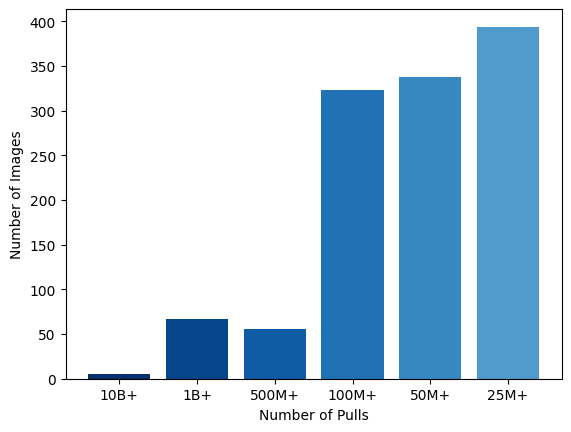

In [9]:
fig, ax = plt.subplots()
N = len(pull_labels)
cmap = plt.get_cmap('Blues_r', N+7)
colors = [cmap(i) for i in range(N)]
ax.bar(pull_labels, pull_values, color=colors)
ax.set_ylabel('Number of Images')
ax.set_xlabel('Number of Pulls')
plt.savefig(pngpath.format("imagespull"), bbox_inches='tight')
plt.show()

In [10]:
images.head(15).to_clipboard(excel=True)
images.head(15)

,name,short_description,popularity,pulls
0,stakater/reloader,NaN,15707567662,10B+
1,fluent/fluent-bit,"Fluent Bit, lightweight logs and metrics colle...",13504855326,10B+
2,istio/pilot,Istiod (formerly known as Pilot),10892841325,10B+
3,istio/proxyv2,Istio proxy,10856258988,10B+
4,datadog/agent,Docker container for the new Datadog Agent,10506175135,10B+
5,containrrr/watchtower,A process for automating Docker container base...,8081190948,1B+
6,curlimages/curl,official docker image for curl - command line ...,5942630776,1B+
7,istio/operator,Istio in-cluster operator,5906215271,1B+
8,envoyproxy/envoy,Cloud-native high-performance edge/middle/serv...,5039382115,1B+
9,jenkins/jenkins,The leading open source automation server,4595243622,1B+


# tags_clean

In [11]:
tags_flat = json.load(open("../tags/tags_random_amd64/tags_flat_3000.json"))
tags = json.load(open("../tags/tags_random_amd64/tags_3000.json"))
len(tags_flat)

3207

In [12]:
tags_clean = []

for tag in tags_flat:
    filename = tag.replace("/", "_").replace(":", "_")
    if os.path.exists(f"../final_results/per_tag_res2/{filename}.json"):
        tags_clean.append(tag)

In [13]:
len(tags_clean)

3191

In [14]:
# error tags
len(tags_flat) - len(tags_clean)

16

# images distro

In [15]:
tags_distro = []

for tag in tags_clean:
    filename = tag.replace("/", "_").replace(":", "_")
    with open(f"../final_results/per_tag_res/{filename}.json", "r") as f:
        data = json.load(f)
        distro = []
        for s in scanners:
            for entry in data[s]:
                d = entry.get("distro")
                if d and d not in distro and d not in ["Unsupported OS", ['', '']]:
                    distro.append(d)
    tags_distro.append({"tag": tag, "distro": distro})
        

In [16]:
tags_distro_short = []

for entry in tags_distro:
    res = {"tag": entry["tag"], "distro": set()}
    for os in ["redhat", "alpine", "ubuntu", "debian", "busybox", "buildroot", "amazonlinux", "centos"]:
        if os in str(entry["distro"]):
            res["distro"].add(os)
    if not res["distro"]:
        res["distro"].add("other")
    res["distro"] = list(res["distro"])
    tags_distro_short.append(res)

In [17]:
image_distro = []

for entry in tags_distro_short:
    image = entry["tag"].split(":")[0]
    if not next((d for d in image_distro if d["image"] == image), None):
        res = {"image": image, "distro": entry["distro"][0]}
        image_distro.append(res)

len(image_distro)

1145

In [18]:
image_distro_df = pd.DataFrame.from_dict(image_distro)
image_distro_df["distro"].value_counts()

distro
alpine         438
debian         249
ubuntu         206
other           94
busybox         50
redhat          40
centos          38
buildroot       17
amazonlinux     13
Name: count, dtype: int64

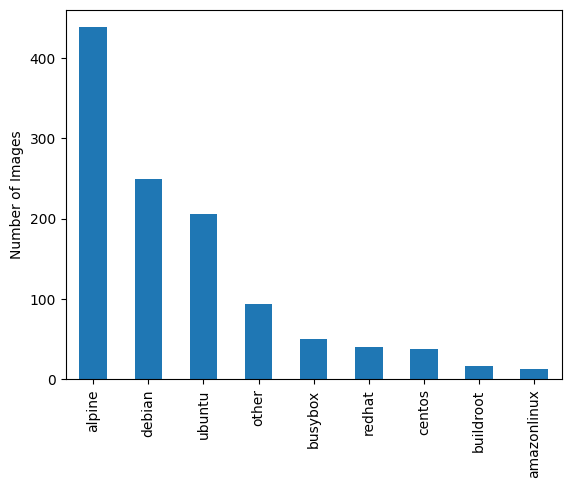

In [19]:
ax = image_distro_df["distro"].value_counts().sort_values(ascending=False).plot(kind = "bar", xlabel="", ylabel="Number of Images")
fig = ax.get_figure()
fig.savefig(pngpath.format("imagesdistro"), bbox_inches="tight")

# tags date

In [106]:
tags_date = []

for image in tags:
    for tag in tags[image]:
        if tag in tags_clean:
            tags_date.append({"tag": tag, "timestamp": tags[image][tag]})

In [107]:
# remove time
for entry in tags_date:
    entry["date"] = entry["timestamp"].split("T")[0]
    entry.pop("timestamp")

In [108]:
pd.DataFrame.from_dict(tags_date)

,tag,date
0,stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2,2024-04-17
1,stakater/reloader:SNAPSHOT-PR-595-3f903788,2024-02-07
2,stakater/reloader:SNAPSHOT-PR-573-UBI-b599ad5e,2024-03-27
3,fluent/fluent-bit:3.0.1,2024-04-04
4,fluent/fluent-bit:2.0.3-debug,2022-10-28
...,...,...
3186,maxmindinc/geoipupdate:v6.1,2024-01-09
3187,directus/directus:9.15.1,2022-08-05
3188,directus/directus:v9-rc.83,2021-07-07
3189,directus/directus:10.7,2023-11-02


In [109]:
tags_year = []
for entry in tags_date:
    tags_year.append({"tag": entry["tag"], "year": int(entry["date"].split("-")[0])})

In [110]:
tags_year_df = pd.DataFrame.from_dict(tags_year)
tags_year_df

,tag,year
0,stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2,2024
1,stakater/reloader:SNAPSHOT-PR-595-3f903788,2024
2,stakater/reloader:SNAPSHOT-PR-573-UBI-b599ad5e,2024
3,fluent/fluent-bit:3.0.1,2024
4,fluent/fluent-bit:2.0.3-debug,2022
...,...,...
3186,maxmindinc/geoipupdate:v6.1,2024
3187,directus/directus:9.15.1,2022
3188,directus/directus:v9-rc.83,2021
3189,directus/directus:10.7,2023


In [111]:
tags_year_df["year"].value_counts().sort_index()

year
2016     72
2017    161
2018    227
2019    338
2020    389
2021    416
2022    528
2023    741
2024    319
Name: count, dtype: int64

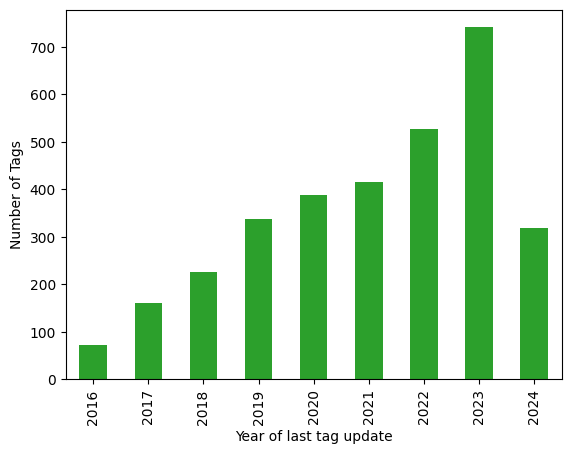

In [151]:
ax = tags_year_df["year"].value_counts().sort_index().plot(kind = "bar", xlabel="Year of last tag update", ylabel="Number of Tags", color="tab:green")
fig = ax.get_figure()
fig.savefig(pngpath.format("tagsyear"), bbox_inches="tight")

# make list of confirmed vulnerabilities for each tag

In [27]:
others = 2

In [28]:
per_tag = []
for tag in tags_clean:
    filename = tag.replace(":", "_").replace("/", "_")
    with open(f"../final_results/per_tag_res2/{filename}.json", "r") as f:
        per_tag.append(json.load(f))

In [29]:
counter = 0

per_tag_expand = []
for tag in tags_clean:
    d = next(t for t in per_tag if t["tag"] == tag)
    records = []
    for aggr in d["aggr"]:
        if aggr["conf_count_others"] >= others:
            expanded_record = {"aggrid": aggr["uid"]}
            for s in scanners:
                expanded_record[s] = []
            for s in aggr["links"]:
                for link in aggr["links"][s]:
                    entry = next(q for q in d[s] if q["uid"] == link)
                    expanded_record[s].append(entry)
            records.append(expanded_record)
    per_tag_expand.append({"tag": tag, "records": records})

    counter += 1
    if counter % 100 == 0:
        print(counter)

    

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100


In [31]:
per_tag_expand[0]

{'tag': 'stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2',
 'records': [{'aggrid': 'aggr0',
   'clair': [{'id': 'CVE-2021-39537',
     'cve_id': 'CVE-2021-39537',
     'sas': ['CVE-2021-39537'],
     'severity': 'low',
     'package': 'ncurses-libs',
     'distro': 'cpe:2.3:o:redhat:enterprise_linux:8:*:*:*:*:*:*:*',
     'fixed': False,
     'tag': 'stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2',
     'uid': 'clair63'},
    {'id': 'CVE-2021-39537',
     'cve_id': 'CVE-2021-39537',
     'sas': ['CVE-2021-39537'],
     'severity': 'low',
     'package': 'ncurses-base',
     'distro': 'cpe:2.3:o:redhat:enterprise_linux:8:*:*:*:*:*:*:*',
     'fixed': False,
     'tag': 'stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2',
     'uid': 'clair194'},
    {'id': 'CVE-2021-39537',
     'cve_id': 'CVE-2021-39537',
     'sas': ['CVE-2021-39537'],
     'severity': 'low',
     'package': 'ncurses-base',
     'distro': 'cpe:2.3:o:redhat:enterprise_linux:8:*:*:*:*:*:*:*',
     'fixed': False,
     'tag'

In [32]:
def merge_record(d):
    res = {"aggrid": d["aggrid"], "sas": [], "severity": [], "package": [], "fixed": []}
    for s in scanners:
        # print(record[s])
        for subrecord in d[s]:
            res["sas"].extend(subrecord["sas"])
            res["severity"].append(subrecord["severity"])
            package = subrecord["package"]
            if isinstance(package, list):
                package = " ".join(package)
            res["package"].append(package)
            res["fixed"].append(subrecord["fixed"])
    # print(res)
            
    # res["sas"] = list(set(res["sas"]))
    # res["severity"] = list(set(res["severity"]))
    res["package"] = list(set(res["package"]))
    # res["fixed"] = list(set(res["fixed"]))
    return res

In [33]:
counter = 0
per_tag_shrink = []

for tag_entry in per_tag_expand:
    res = {"tag": tag_entry["tag"], "records": []}
    for record in tag_entry["records"]:
        res["records"].append(merge_record(record))
    per_tag_shrink.append(res)

    counter += 1
    if counter % 100 == 0:
        print(counter)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100


In [34]:
per_tag_shrink[1]

{'tag': 'stakater/reloader:SNAPSHOT-PR-595-3f903788',
 'records': [{'aggrid': 'aggr0',
   'sas': ['CVE-2024-24786',
    'GHSA-8r3f-844c-mc37',
    'CVE-2024-24786',
    'CVE-2024-24786',
    'CVE-2024-24786'],
   'severity': ['medium', 'medium', 'medium', 'warning'],
   'package': ['google.golang.org/protobuf@v1.31.0',
    'google.golang.org/protobuf',
    'pkg:golang/google.golang.org/protobuf@1.31.0'],
   'fixed': [True, True, True, '']},
  {'aggrid': 'aggr1',
   'sas': ['CVE-2023-45288',
    'CVE-2023-45288',
    'GHSA-4v7x-pqxf-cx7m',
    'CVE-2023-45288',
    'CVE-2023-45288',
    'CVE-2023-45288',
    'CVE-2023-45288',
    'CVE-2023-45288'],
   'severity': ['medium',
    'medium',
    'unknown',
    'unspecified',
    'unspecified',
    7.5,
    'warning'],
   'package': ['golang.org/x/net',
    'golang.org/x/net@v0.17.0',
    'golang.org/x/net/http2@v0.17.0',
    'stdlib',
    'pkg:golang/golang.org/x/net@0.17.0 pkg:golang/stdlib@1.21.6'],
   'fixed': [True, True, False, True, T

## make flat

In [38]:
flat = []

for tag_entry in per_tag_shrink:
    for record in tag_entry["records"]:
        flat.append(
            {
                "tag": tag_entry["tag"], 
                "aggrid": record["aggrid"],
                "sas": record["sas"],
                "severity": record["severity"],
                "package": record["package"],
                "fixed": record["fixed"]
            }
        )

In [36]:
json.dump(flat, open("flat.json", "w"), indent=4)

In [37]:
flat = json.load(open("flat.json", "r"))

In [40]:
flat[0]

{'tag': 'stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2',
 'aggrid': 'aggr0',
 'sas': ['CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537'],
 'severity': ['low',
  'low',
  'low',
  'low',
  'low',
  'low',
  'low',
  'low',
  5.5,
  5.5,
  'note',
  'note'],
 'package': ['ncurses-libs@6.1-10.20180224.el8',
  'ncurses-base',
  'pkg:rpm/redhatlinux/ncurses@6.1-10.20180224.el8?os_name=redhatlinux&os_version=8',
  'ncurses-libs',
  'ncurses-base@6.1-10.20180224.el8'],
 'fixed': [False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  '',
  '']}

## переводим из списка в одно значение

### fixed

In [41]:
def get_most_freq(lst):
    cnt = Counter(lst)
    res = [e for e, count in cnt.items() if count == max(cnt.values())]
    if "" in res:
        res.remove("")
    return res


In [42]:
for entry in flat:
    res = get_most_freq(entry["fixed"])
    if len(res) == 1:
        entry["fixed"] = res[0]
    else:
        entry["fixed"] = None

### severity

In [43]:
all_severity = set()
for record in flat:
    for v in record["severity"]:
        all_severity.add(v)
all_severity

{0,
 1.9,
 10,
 2,
 2.1,
 2.2,
 2.3,
 2.4,
 2.5,
 2.6,
 2.7,
 2.8,
 2.9,
 3,
 3.1,
 3.2,
 3.3,
 3.4,
 3.5,
 3.6,
 3.7,
 3.8,
 3.9,
 4,
 4.1,
 4.2,
 4.3,
 4.4,
 4.5,
 4.6,
 4.7,
 4.8,
 4.9,
 5,
 5.1,
 5.2,
 5.3,
 5.4,
 5.5,
 5.6,
 5.7,
 5.8,
 5.9,
 6,
 6.1,
 6.2,
 6.3,
 6.4,
 6.5,
 6.6,
 6.7,
 6.8,
 7,
 7.1,
 7.2,
 7.3,
 7.4,
 7.5,
 7.6,
 7.7,
 7.8,
 7.9,
 8,
 8.1,
 8.2,
 8.3,
 8.4,
 8.5,
 8.6,
 8.7,
 8.8,
 9,
 9.1,
 9.3,
 9.4,
 9.6,
 9.8,
 9.9,
 None,
 'critical',
 'error',
 'high',
 'low',
 'medium',
 'negligible',
 'note',
 'unknown',
 'unspecified',
 'warning'}

In [44]:
for record in flat:
    for v in record["severity"]:
        s_severity = []
        if isinstance(v, float) or isinstance(v, int):
            if v >= 9:
                s_severity.append("critical")
            elif v >= 7:
                s_severity.append("high")
            elif v >= 4:
                s_severity.append("medium")
            elif v >= 0.1:
                s_severity.append("low")
            else:
                s_severity.append("none")
        elif v == "unspecified":
            s_severity.append("unknown")
        elif v == "negligible":
            s_severity.append("none")
        elif v == "note":
            s_severity.append("low")
        elif v == "warning":
            s_severity.append("medium")
        elif v == "error":
            s_severity.append("high")
        elif v is None:
            s_severity.append("none")
        else:
            s_severity.append(v)
    record["severity"] = s_severity

In [45]:
for record in flat:
    record["severity"] = record["severity"][0]

In [46]:
all_severity = set()
for record in flat:
    all_severity.add(record["severity"])
all_severity

{'critical', 'high', 'low', 'medium', 'none', 'unknown'}

### packages

#### download

In [52]:
per_tag_packages = []

for entry in flat:
    res = {"tag": entry["tag"], "aggrid": entry["aggrid"], "package": entry["package"]}
    per_tag_packages.append(res)

In [53]:
with open("packages.json", "w") as f:
    json.dump(per_tag_packages, f, indent=4)

#### upload back

In [55]:
with open("packages_res_clean.json", "r") as f:
    per_tag_packages_clean = json.load(f)

In [56]:
per_tag_packages_clean[0]

{'tag': 'stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2',
 'aggrid': 'aggr0',
 'package': 'ncurses'}

In [187]:
len(flat)

718607

In [66]:
for record in flat:
    record["package"] = None

In [68]:
counter = 0
for record in flat:
    if not record["package"]:
        tag = record["tag"]
        aggrid = record["aggrid"]
        package = next(d for d in per_tag_packages_clean if d["tag"] == tag and d["aggrid"] == aggrid)
        # print(package["package"])
        record["package"] = package["package"]
        per_tag_packages_clean.remove(package)
    
    counter += 1
    if counter % 10000 == 0: print(counter)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000


In [77]:
flat[0]

{'tag': 'stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2',
 'aggrid': 'aggr0',
 'sas': ['CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537',
  'CVE-2021-39537'],
 'severity': 'low',
 'package': 'ncurses',
 'fixed': False}

### cveid

In [93]:
for record in flat:
    sas = record["sas"]
    res = get_most_freq(sas)
    if len(res) == 1:
        record["cveid"] = res[0]
    else:
        if len(res) == 2 and "CVE" in str(res) and "GHSA" in str(res):
            record["cveid"] = res[0] if "CVE" in res[0] else res[1]
        elif len(res) == 2 and "GHSA" in str(res):
            record["cveid"] = ""
        else:
            record["cveid"] = max(res)
            print(record["cveid"])
            

CVE-2023-46218
CVE-2021-35939
CVE-2022-48564
CVE-2023-46218
CVE-2022-48339
CVE-2019-15903
CVE-2019-14822
CVE-2022-23219
CVE-2020-29573
CVE-2019-5188
CVE-2020-7595
CVE-2020-6829
CVE-2019-11745
CVE-2020-25710
CVE-2021-23841
CVE-2022-43552
CVE-2023-46218
CVE-2023-2283
CVE-2023-0286
CVE-2022-42012
CVE-2023-28321
CVE-2023-4911
CVE-2023-2603
CVE-2022-40304
CVE-2021-35939
CVE-2023-29469
CVE-2024-28835
CVE-2024-28757
CVE-2024-28757
CVE-2024-28835
CVE-2024-26461
CVE-2021-36087
CVE-2020-19190
CVE-2023-48237
CVE-2023-5535
CVE-2024-26461
CVE-2022-23219
CVE-2021-35942
CVE-2023-0286
CVE-2023-2603
CVE-2021-35939
CVE-2019-17595
CVE-2021-23841
CVE-2023-4911
CVE-2020-13776
CVE-2020-14155
CVE-2022-23219
CVE-2023-4911
CVE-2021-35939
CVE-2023-0286
CVE-2023-2603
CVE-2023-4911
CVE-2023-28321
CVE-2023-2283
CVE-2019-19204
CVE-2023-46218
CVE-2023-29469
CVE-2023-2603
CVE-2021-35939
CVE-2024-26462
CVE-2021-35939
CVE-2023-38546
CVE-2023-28322
CVE-2023-27538
CVE-2023-32665
CVE-2024-26462
CVE-2023-39975
CVE-2023-294

In [105]:
with open(f"../final_results/per_tag_shrink.json", "w") as f:
    json.dump(flat, f, indent=4)

# analyse vulnerabilities and packages and dates

In [366]:
flat_df = pd.DataFrame.from_dict(flat)

In [367]:
flat_df

,tag,aggrid,sas,severity,package,fixed,cveid
0,stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2,aggr0,"[CVE-2021-39537, CVE-2021-39537, CVE-2021-3953...",low,ncurses,False,CVE-2021-39537
1,stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2,aggr1,"[CVE-2019-8905, CVE-2019-8905, CVE-2019-8905, ...",low,file-libs,False,CVE-2019-8905
2,stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2,aggr2,"[CVE-2022-4899, CVE-2022-4899, CVE-2022-4899, ...",low,libzstd,False,CVE-2022-4899
3,stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2,aggr3,"[CVE-2021-4209, CVE-2021-4209, CVE-2021-4209, ...",low,gnutls,False,CVE-2021-4209
4,stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2,aggr4,"[CVE-2024-2398, CVE-2024-2398, CVE-2024-2398, ...",medium,curl,False,CVE-2024-2398
...,...,...,...,...,...,...,...
718602,ackstorm/relk-filebeat:v7,aggr139,"[CVE-2021-24031, CVE-2021-24031, CVE-2021-2403...",medium,libzstd,True,CVE-2021-24031
718603,ackstorm/relk-filebeat:v7,aggr140,"[CVE-2019-17543, CVE-2019-17543, CVE-2019-1754...",low,lz4,False,CVE-2019-17543
718604,ackstorm/relk-filebeat:v7,aggr141,"[CVE-2021-20232, CVE-2021-20232, CVE-2021-2023...",high,gnutls,True,CVE-2021-20232
718605,ackstorm/relk-filebeat:v7,aggr142,"[CVE-2022-37434, CVE-2022-37434, CVE-2022-3743...",high,zlib,True,CVE-2022-37434


In [368]:
# add year

flat_df = flat_df.merge(tags_year_df)

In [369]:
# add cve year

def cve_year(row):
   if "CVE-" in row["cveid"]:
      return row["cveid"].split("-")[1]
   return None

flat_df["cveyear"] = flat_df.apply(cve_year, axis=1)

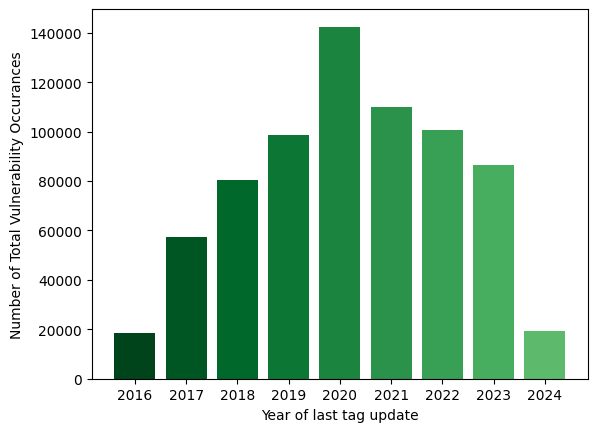

In [450]:
# неуникальные уязвимости по годам

c = flat_df.groupby(['year']).size().reset_index(name='counts')

fig, ax = plt.subplots()
N = len(c["year"])
cmap = plt.get_cmap('Greens_r', N+10)
colors = [cmap(i) for i in range(N)]
ax.bar(c["year"], c["counts"], color=colors, tick_label=c["year"])
# ax.set_xticks(np.arange(len(c["year"])))
# set_xticklabels()
ax.set_ylabel('Number of Total Vulnerability Occurances')
ax.set_xlabel('Year of last tag update')
plt.savefig(pngpath.format("vulnstagyear"), bbox_inches='tight')
plt.show()

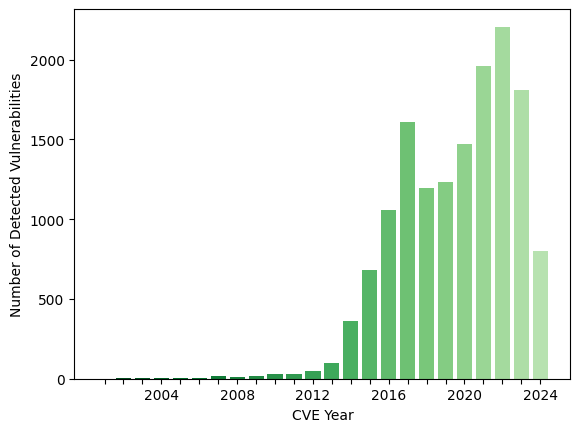

In [451]:
# уникальные cve по годам 

subset = flat_df.drop_duplicates(["cveid"]).groupby(['cveyear']).size().reset_index(name='counts')

fig, ax = plt.subplots()
N = len(subset["cveyear"])
cmap = plt.get_cmap('Greens_r', N+10)
colors = [cmap(i) for i in range(N)]

xtick = [""] * len(subset["cveyear"])
for i in range(len(subset["cveyear"])):
    if i % 4 == 3:
        xtick[i] = subset["cveyear"][i]

ax.bar(subset["cveyear"], subset["counts"], color=colors, tick_label=xtick)
ax.set_ylabel('Number of Detected Vulnerabilities')
ax.set_xlabel('CVE Year')
plt.savefig(pngpath.format("vulnscveyear"), bbox_inches='tight')
plt.show()

In [375]:
# drop na

flat_df.dropna(subset=["year", "cveyear"], inplace=True)

In [376]:
flat_df['year'] = flat_df['year'].astype('int')
flat_df['cveyear'] = flat_df['cveyear'].astype('int')

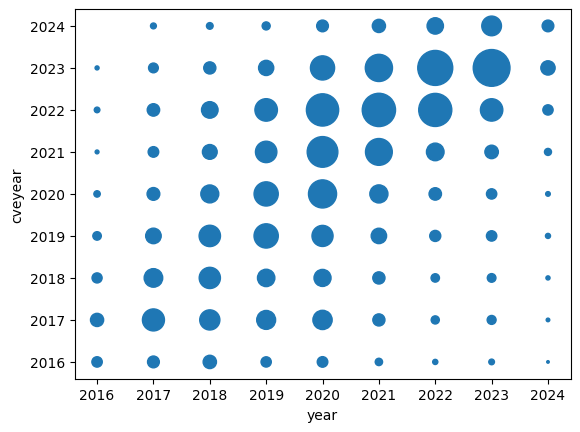

In [266]:
# уязвимости по году — год образа скаттерплот
subset = flat_df[flat_df["cveyear"] > 2015].groupby(["year", "cveyear"]).size().reset_index(name='counts').sort_values(["year", "cveyear"])
subset


fig, ax = plt.subplots()
# N = len(subset["cveyear"])
# cmap = plt.get_cmap('Greens_r', N+10)
# colors = [cmap(i) for i in range(N)]
data = subset["counts"]
s = (data - np.min(data)) / (np.max(data) - np.min(data)) * 700
ax.scatter(x=subset['year'], y=subset['cveyear'], s=s)
ax.set_ylabel('CVE Year')
ax.set_xlabel('year')
plt.savefig(pngpath.format("vulnscveyear"), bbox_inches='tight')
plt.show()



# N = len(subset['year'])


# plt.

# flat_df.plot.scatter(x='Ice_cream_sales', y='Temperature')


In [455]:
subset = flat_df[flat_df["cveyear"] > 2015][["year", "cveyear"]]
subset

,year,cveyear
0,2024,2021
1,2024,2019
2,2024,2022
3,2024,2021
4,2024,2024
...,...,...
718602,2019,2021
718603,2019,2019
718604,2019,2021
718605,2019,2022


In [456]:
def add_rand_year(row):
    return row["year"] + np.random.normal(0, 0.5, size=1)[0]

def add_rand_cveyear(row):
    return row["cveyear"] + np.random.normal(0, 0.5, size=1)[0]

subset["year_d"] = subset.apply(add_rand_year, axis=1)
subset["cveyear_d"] = subset.apply(add_rand_cveyear, axis=1)

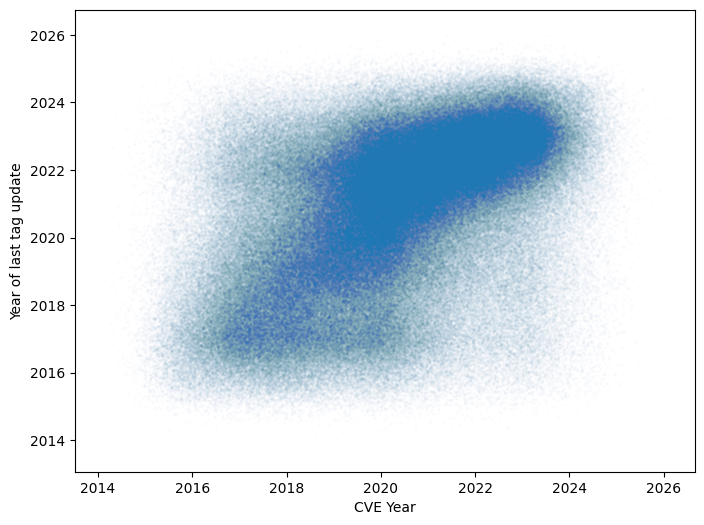

In [457]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

ax.scatter(x=subset['year_d'], y=subset['cveyear_d'], s=2, alpha=0.011)
ax.set_ylabel('Year of last tag update')
ax.set_xlabel('CVE Year')
plt.savefig(pngpath.format("vulnscveyearsc"), bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
fig, ax = plt.subplots()
# N = len(subset["cveyear"])
# cmap = plt.get_cmap('Greens_r', N+10)
# colors = [cmap(i) for i in range(N)]
# data = subset["counts"]
# s = (data - np.min(data)) / (np.max(data) - np.min(data)) * 100
ax.scatter(x=subset['year_d'], y=subset['cveyear_d'], s=0.69, alpha=0.006)
ax.set_ylabel('Number of Detected Vulnerabilities')
ax.set_xlabel('CVE Year')
plt.savefig(pngpath.format("vulnscveyearsc"), bbox_inches='tight', dpi=600)
plt.show()

In [386]:
# most frequent cves
flat_df.groupby(["cveid", "cveyear"]).size().reset_index(name='tags').sort_values("tags", ascending=False)[:15]

In [389]:
# oldest cves
flat_df.groupby(["cveid", "cveyear"]).size().reset_index(name='tags').sort_values("cveyear")[:15].to_clipboard(excel=True)


In [443]:
# most vulnerable packages by occurences
flat_df.groupby(["package"]).size().reset_index(name='tags').sort_values("tags", ascending=False)[:40].to_clipboard(excel=True)

In [447]:
# most vulnerable packages by unique cves
flat_df.groupby(["package", "cveid"]).size().reset_index(name='tags').groupby("package").size().reset_index(name='tags').sort_values("tags", ascending=False)[:30].to_clipboard(excel=True)


In [449]:
# most frequent packages
flat_df.groupby(["package", "tag"]).size().reset_index(name='tags').groupby("package").size().reset_index(name='tags').sort_values("tags", ascending=False)[:30].to_clipboard(excel=True)


In [459]:
# how many clear images?????

dirty_tags = [r["tag"] for r in flat]

In [461]:
len(set(dirty_tags))

2972

In [468]:
tags_with_no_cve = list(set(tags_clean) - set(dirty_tags))
len(tags_with_no_cve)

219

In [520]:
len(tags_with_no_cve) / len(set(tags_clean)) * 100

6.863052334691319

In [495]:
# распределение по скору

def add_max_severity(row):
    if "critical" in row["all_s"]:
        return "critical"
    if "high" in row["all_s"]:
        return "high"
    if "medium" in row["all_s"]:
        return "medium"
    if "low" in row["all_s"]:
        return "low"
    if "none" in row["all_s"]:
        return "none"
    if "unknown" in row["all_s"]:
        return "unknown"

# flat_df["max_severity"] = flat_df.apply(add_max_severity, axis=1)

In [501]:
subset = flat_df.groupby(["tag", "severity"]).size().reset_index(name='new')
subset = subset.groupby(["tag"])["severity"].apply(list).reset_index(name='all_s')
subset["max_severity"] = subset.apply(add_max_severity, axis=1)
subset = subset[["tag", "max_severity"]].groupby("max_severity").size().reset_index(name='counts')

In [512]:
list(subset["counts"])

[1234, 1610, 21, 106]

In [513]:
list(subset["max_severity"])

['critical', 'high', 'low', 'medium']

In [515]:
x = ['critical', 'high', 'medium', 'low', 'not vulnerable']
y = [1234, 1610, 106, 21, len(tags_with_no_cve)]

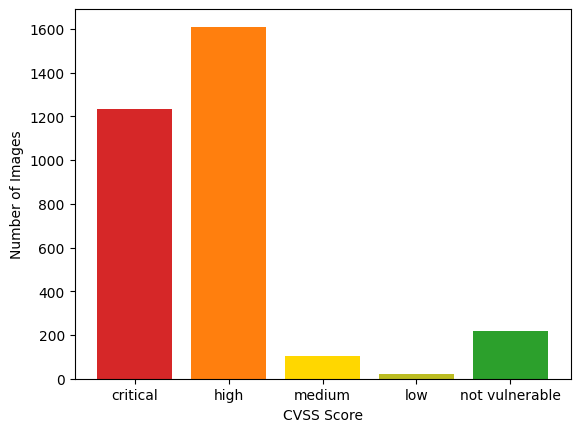

In [517]:
fig, ax = plt.subplots()
N = len(x)
cmap = plt.get_cmap('Blues_r', N+7)
# colors = [cmap(i) for i in range(N)]
ax.bar(x, y, color=["tab:red", "tab:orange", "gold", "tab:olive", "tab:green"])
ax.set_ylabel('Number of Images')
ax.set_xlabel('CVSS Score')
plt.savefig(pngpath.format("tagscvescore"), bbox_inches='tight')
plt.show()

In [548]:
# most vulnerable tags
subset = flat_df.groupby(["tag", "year", "cveid"]).size().reset_index(name='counts')#.to_clipboard(excel=True)
subset = subset.groupby(["tag", "year"]).size().reset_index(name='counts')
subset.sort_values("counts", ascending=False)[:15]


,tag,year,counts
1974,nexcess/php-fpm:php71,2020,3131
1976,nexcess/php-fpm:php74,2020,3026
1975,nexcess/php-fpm:php73,2020,3026
179,appuio/s2i-maven-java:fix_skiptests,2018,2943
180,appuio/s2i-maven-java:latest,2018,2943
2705,stevenctimm/gpgridvanilla:latest,2017,2686
2703,stevenctimm/gpgridvanilla:fkhan_add_rpms,2017,2686
1006,eclipse/che-dev:7.0.0-beta-4.0,2019,2639
1005,eclipse/che-dev:7.0.0-beta-1.0,2019,2634
1004,eclipse/che-dev:6.17.1,2019,2634


In [560]:
# most vulnerable images

subset = flat_df.groupby(["image", "year", "cveid"]).size().reset_index(name='counts')#.to_clipboard(excel=True)
subset = subset.groupby(["image", "year"]).size().reset_index(name='cves')
subset = subset.sort_values("cves", ascending=False)[:15]


In [561]:
subset = subset.merge(images, how="left", left_on="image", right_on="name")
subset = subset.drop(["name"], axis=1)
subset.to_clipboard(excel=True)
subset

,image,year,cves,short_description,popularity,pulls
0,nexcess/php-fpm,2020,3131,NaN,41077968,25M+
1,appuio/s2i-maven-java,2018,2943,S2I Builder with Maven and Java,30071644,25M+
2,stevenctimm/gpgridvanilla,2017,2688,NaN,44445325,25M+
3,civisanalytics/civis-jupyter-r,2020,2664,Custom Jupyter Notebook image for R.,48710085,25M+
4,eclipse/che-dev,2019,2639,NaN,92431926,50M+
5,civisanalytics/civis-jupyter-python3,2020,2205,Custom Jupyter Notebook image for Python 3,49865863,25M+
6,broadinstitute/gatk,2020,2101,Official release repository for GATK versions 4.x,33406661,25M+
7,scrapinghub/splash,2017,1824,"Lightweight, scriptable browser as a service w...",72899470,50M+
8,civisanalytics/civis-jupyter-python2,2019,1818,Custom Jupyter Notebook image for Python 2.,47991236,25M+
9,bugswarm/artifacts,2018,1809,The old repository for BugSwarm artifact images.,165281953,100M+


In [552]:
images

,name,short_description,popularity,pulls
0,stakater/reloader,NaN,15707567662,10B+
1,fluent/fluent-bit,"Fluent Bit, lightweight logs and metrics colle...",13504855326,10B+
2,istio/pilot,Istiod (formerly known as Pilot),10892841325,10B+
3,istio/proxyv2,Istio proxy,10856258988,10B+
4,datadog/agent,Docker container for the new Datadog Agent,10506175135,10B+
...,...,...,...,...
1178,edwardcarmack/gearforce-web,NaN,29534504,25M+
1179,rancher/dns,NaN,29531302,25M+
1180,maxmindinc/geoipupdate,Use ghcr.io/maxmind/geoipupdate for new releases,29463326,25M+
1181,directus/directus,"Directus is an open-source ""headless"" CMS & AP...",29400874,25M+


In [566]:
# vulnerabilities in image and popularity
subset = flat_df.groupby(["image", "year", "cveid"]).size().reset_index(name='counts')#.to_clipboard(excel=True)
subset = subset.groupby(["image"]).size().reset_index(name='cves')
subset = subset.merge(images, how="left", left_on="image", right_on="name")
subset = subset[["cves", "popularity"]]
subset

,cves,popularity
0,464,281273592
1,5,49352383
2,87,45845142
3,30,32933215
4,24,111504015
...,...,...
1088,148,30100242
1089,57,37710072
1090,169,34854394
1091,406,98291274


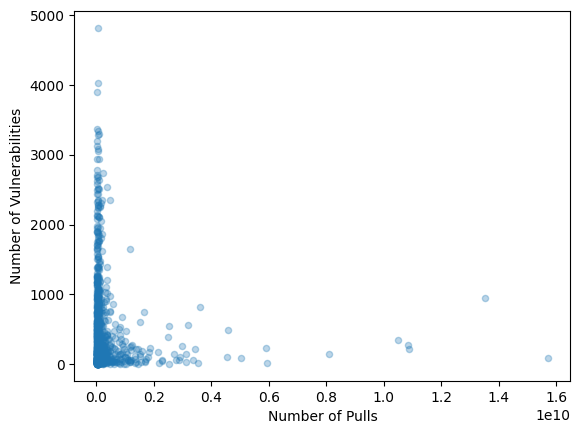

In [578]:
fig, ax = plt.subplots()
# fig.set_size_inches(8, 6)

ax.scatter(x=subset['popularity'], y=subset['cves'], s=20, alpha=0.3)
ax.set_ylabel('Number of Vulnerabilities')
ax.set_xlabel('Number of Pulls')
plt.savefig(pngpath.format("imagescvessc"), bbox_inches='tight', dpi=600)
plt.show()

# scanners

In [427]:
# add distro
def add_image(row):
    image = row["tag"].split(":")[0]
    # distro = next(i for i in image_distro if i["image"] == image)
    return image

def add_distro(row):
    image = row["image"]
    distro = next(i for i in image_distro if i["image"] == image)
    return distro["distro"]

flat_df["image"] = flat_df.apply(add_image, axis=1)
flat_df["distro"] = flat_df.apply(add_distro, axis=1)

In [428]:
flat_df

,tag,aggrid,sas,severity,package,fixed,cveid,year,cveyear,image,distro
0,stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2,aggr0,"[CVE-2021-39537, CVE-2021-39537, CVE-2021-3953...",low,ncurses,False,CVE-2021-39537,2024,2021,stakater/reloader,redhat
1,stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2,aggr1,"[CVE-2019-8905, CVE-2019-8905, CVE-2019-8905, ...",low,file-libs,False,CVE-2019-8905,2024,2019,stakater/reloader,redhat
2,stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2,aggr2,"[CVE-2022-4899, CVE-2022-4899, CVE-2022-4899, ...",low,libzstd,False,CVE-2022-4899,2024,2022,stakater/reloader,redhat
3,stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2,aggr3,"[CVE-2021-4209, CVE-2021-4209, CVE-2021-4209, ...",low,gnutls,False,CVE-2021-4209,2024,2021,stakater/reloader,redhat
4,stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2,aggr4,"[CVE-2024-2398, CVE-2024-2398, CVE-2024-2398, ...",medium,curl,False,CVE-2024-2398,2024,2024,stakater/reloader,redhat
...,...,...,...,...,...,...,...,...,...,...,...
718602,ackstorm/relk-filebeat:v7,aggr139,"[CVE-2021-24031, CVE-2021-24031, CVE-2021-2403...",medium,libzstd,True,CVE-2021-24031,2019,2021,ackstorm/relk-filebeat,debian
718603,ackstorm/relk-filebeat:v7,aggr140,"[CVE-2019-17543, CVE-2019-17543, CVE-2019-1754...",low,lz4,False,CVE-2019-17543,2019,2019,ackstorm/relk-filebeat,debian
718604,ackstorm/relk-filebeat:v7,aggr141,"[CVE-2021-20232, CVE-2021-20232, CVE-2021-2023...",high,gnutls,True,CVE-2021-20232,2019,2021,ackstorm/relk-filebeat,debian
718605,ackstorm/relk-filebeat:v7,aggr142,"[CVE-2022-37434, CVE-2022-37434, CVE-2022-3743...",high,zlib,True,CVE-2022-37434,2019,2022,ackstorm/relk-filebeat,debian


In [431]:
# vulnerabilities per distro

flat_df.groupby(["cveid", "distro"]).size().reset_index(name='tags').groupby("distro").size().reset_index(name='tags').sort_values("tags", ascending=False)


,distro,tags
8,ubuntu,10774
5,debian,8249
4,centos,5893
0,alpine,5048
7,redhat,2951
6,other,1761
1,amazonlinux,1228
2,buildroot,588
3,busybox,528


In [432]:
flat_df.groupby(["distro"]).size().reset_index(name='tags').sort_values("tags", ascending=False)


,distro,tags
8,ubuntu,257088
5,debian,238568
4,centos,94866
0,alpine,76138
7,redhat,29748
6,other,10565
3,busybox,3233
1,amazonlinux,2859
2,buildroot,755


In [ ]:
# score

In [397]:
# зависимость от ос

flat_df[flat_df["cveid"] == "CVE-2005-4890"]

,tag,aggrid,sas,severity,package,fixed,cveid,year,cveyear
102895,bugswarm/artifacts:HubSpot-Singularity-154846255,aggr345,"[CVE-2005-4890, CVE-2005-4890, CVE-2005-4890, ...",high,passwd,False,CVE-2005-4890,2018,2005
104767,bugswarm/artifacts:ccnmtl-dmt-88807719,aggr456,"[CVE-2005-4890, CVE-2005-4890, CVE-2005-4890, ...",high,passwd,False,CVE-2005-4890,2018,2005
106631,bugswarm/artifacts:getsentry-sentry-109046394,aggr654,"[CVE-2005-4890, CVE-2005-4890, CVE-2005-4890, ...",high,passwd,False,CVE-2005-4890,2018,2005


In [ ]:


https://nvd.nist.gov/vuln/detail/CVE-2024-0727
https://nvd.nist.gov/vuln/detail/CVE-2023-44487
https://nvd.nist.gov/vuln/detail/CVE-2023-5678
https://nvd.nist.gov/vuln/detail/CVE-2023-3446
https://nvd.nist.gov/vuln/detail/CVE-2023-3817
https://nvd.nist.gov/vuln/detail/CVE-2024-2961
https://nvd.nist.gov/vuln/detail/CVE-2023-2650
https://nvd.nist.gov/vuln/detail/CVE-2016-2781
https://nvd.nist.gov/vuln/detail/CVE-2023-50495
https://nvd.nist.gov/vuln/detail/CVE-2023-0465



CVE-2001-1534 one sentence description
CVE-2002-1976 one sentence description
CVE-2002-2439 one sentence description
CVE-2002-2443 one sentence description
CVE-2003-1307 one sentence description
CVE-2003-1580 one sentence description
CVE-2003-1581 one sentence description
CVE-2004-0423 one sentence description
CVE-2004-0971 one sentence description
CVE-2005-4890 one sentence description


In [365]:
len(flat_df["cveid"].unique())  # столько уникальных уязвимостей

14530

In [364]:
flat_df["cveid"].value_counts()

cveid
CVE-2024-0727     1382
CVE-2023-3446     1335
CVE-2023-5678     1300
CVE-2023-3817     1251
CVE-2016-2781     1227
                  ... 
CVE-2022-3311        1
CVE-2022-0460        1
CVE-2022-4177        1
CVE-2023-1812        1
CVE-2022-36031       1
Name: count, Length: 14530, dtype: int64

In [103]:
flat_df[flat_df["tag"] == "stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2"].to_clipboard(excel=True)


In [128]:
per_tag_flat_df[per_tag_flat_df["tag"] == "stakater/reloader:SNAPSHOT-PR-573-UBI-85ed69c2"].to_clipboard(excel=True)

In [ ]:
CVE-2023-32636

In [ ]:

for sc in scanners:
    print("reading", sc)
    with open(f"../final_results/src/{sc}_tags_vulns.json", "r") as f:
        data[sc] = json.load(f)

In [3]:
scanners = ["clair", "gc", "grype", "scout", "snyk", "trivy"]

In [4]:
data = {}
for sc in scanners:
    print("reading", sc)
    with open(f"../final_results/src/{sc}_tags_vulns.json", "r") as f:
        data[sc] = json.load(f)


reading clair
reading gc
reading grype
reading scout
reading snyk
reading trivy


# reorder data

* кладём в папку джейсоны tag.json
* внутри clair ...., gc ..., и так далее

In [8]:
data.keys()

dict_keys(['clair', 'gc', 'grype', 'scout', 'snyk', 'trivy'])

In [9]:
per_tag = []

for tag in tags:
    t = {"tag": tag}
    for s in scanners:
        list_from_s = data[s].get(tag, [])
        t[s] = list_from_s
    per_tag.append(t)

In [10]:
pd.DataFrame.from_dict(per_tag)

,tag,clair,gc,grype,scout,snyk,trivy
0,shockbyte/default-server:latest,"[{'id': 'CVE-2023-29491', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2022-25235', 'cve_id': 'CVE-2022-...","[{'id': 'CVE-2021-39135', 'cve_id': 'CVE-2021-...","[{'id': 'CVE-2022-27458', 'cve_id': 'CVE-2022-...","[{'id': 'CVE-2022-25147', 'cve_id': 'CVE-2022-...","[{'id': 'CVE-2011-3374', 'cve_id': 'CVE-2011-3..."
1,rancher/gitjob:v0.1.57,[],"[{'id': 'CVE-2023-29405', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2023-38545', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2023-45288', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2023-48795', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2023-46402', 'cve_id': 'CVE-2023-..."
2,sonarsoftware/customerportal:9320a217d1654858a...,"[{'id': 'CVE-2016-2781', 'cve_id': 'CVE-2016-2...","[{'id': 'CVE-2023-0286', 'cve_id': 'CVE-2023-0...","[{'id': 'CVE-2022-29217', 'cve_id': 'CVE-2022-...","[{'id': 'CVE-2023-45918', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2016-1585', 'cve_id': 'CVE-2016-1...","[{'id': 'CVE-2022-3715', 'cve_id': 'CVE-2022-3..."
3,prom/mysqld-exporter:v0.15.0-rc.0,[],"[{'id': 'CVE-2023-29405', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2023-48795', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2023-45288', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2023-44487', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2023-48795', 'cve_id': 'CVE-2023-..."
4,armory/front50:2.24.12,"[{'id': 'CVE-2021-22573', 'cve_id': 'CVE-2021-...","[{'id': 'CVE-2022-22978', 'cve_id': 'CVE-2022-...","[{'id': 'CVE-2021-36373', 'cve_id': 'CVE-2021-...","[{'id': 'CVE-2024-23672', 'cve_id': 'CVE-2024-...","[{'id': 'CVE-2021-30139', 'cve_id': 'CVE-2021-...","[{'id': 'CVE-2021-36159', 'cve_id': 'CVE-2021-..."
...,...,...,...,...,...,...,...
3186,nsqio/nsq:v1.3.0,"[{'id': 'CVE-2024-0727', 'cve_id': 'CVE-2024-0...","[{'id': 'CVE-2024-0727', 'cve_id': 'CVE-2024-0...","[{'id': 'CVE-2023-42366', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2023-45288', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2023-6129', 'cve_id': 'CVE-2023-6...","[{'id': 'CVE-2023-6129', 'cve_id': 'CVE-2023-6..."
3187,photoprism/photoprism:230615,[],"[{'id': 'CVE-2023-4623', 'cve_id': 'CVE-2023-4...","[{'id': 'CVE-2023-38473', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2023-45288', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2016-1585', 'cve_id': 'CVE-2016-1...","[{'id': 'CVE-2023-38469', 'cve_id': 'CVE-2023-..."
3188,oznu/homebridge:ubuntu-no-avahi-amd64,"[{'id': 'CVE-2024-2004', 'cve_id': 'CVE-2024-2...","[{'id': 'CVE-2023-42810', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2023-26108', 'cve_id': 'CVE-2023-...","[{'id': 'CVE-2021-34981', 'cve_id': 'CVE-2021-...","[{'id': 'CVE-2016-1585', 'cve_id': 'CVE-2016-1...","[{'id': 'CVE-2023-1981', 'cve_id': 'CVE-2023-1..."
3189,apicurio/apicurio-studio-auth:14.0.0,"[{'id': 'CVE-2020-19188', 'cve_id': 'CVE-2020-...","[{'id': 'CVE-2024-1597', 'cve_id': 'CVE-2024-1...","[{'id': 'CVE-2022-23913', 'cve_id': 'CVE-2022-...","[{'id': 'CVE-2022-2232', 'cve_id': 'CVE-2022-2...","[{'id': '', 'cve_id': '', 'sas': ['CVE-2017-65...","[{'id': 'CVE-2021-3468', 'cve_id': 'CVE-2021-3..."


In [ ]:
tag = "whenlambomoon/zend:latest"

# score

* true positive — сканер назвал уязвимость и другие тоже назвали
* false positive — сканер назвал уязвимость и другие не назвали
* true negative — сканер не назвал уязвимость и другие не назвали — не можем посчитать
* false negative — сканер не назвал уязвимость, а другие назвали


* плюс степень — 1 другой сканер, 2 других сканера, 3 других сканера?


* `cum[key]["cl_truepos"] = len(cum[key]["conf_by_two"] & cves["cl"][key])`
* `cum[key]["cl_falseneg"] = len(cum[key]["conf_by_two"] - cves["cl"][key])`
* `cum[key]["cl_falsepos"] = len(cves["cl"][key] - cum[key]["conf_by_two"])`

In [11]:
s_num = len(scanners)
s_other_num = s_num - 1

# проставить айди

In [12]:
def set_id(d: dict):
    for s in scanners:
        counter = 0
        for entry in d[s]:
            entry["uid"] = s + str(counter)
            counter += 1

# агрегированные записи

```json
{
    "uid": "aggr1",
    "links": [clair1, gc55]
}
```

In [13]:
def get_aggr_entry_by_link(d: dict, s: str, uid):
    for i in d["aggr"]:
        links = sum(i["links"].values(),[])
        if uid in links:
            return i["uid"]
    return None

In [14]:
def get_similar_from_scanner(entry: dict, tag_data: dict, s: str) -> str:
    s_entries = tag_data[s]
    res = []
    for s_entry in s_entries:
        for id in entry["sas"]:
            if id in s_entry["sas"]:
                res.append(s_entry["uid"])
    return res

In [15]:
def make_aggr_entries(d: dict):
    d["aggr"] = []
    counter = 0
    for s in scanners:
        for entry in d[s]:
            r = get_aggr_entry_by_link(d, s, entry["uid"])
            if r:  # есть аггр запись с этой записью из сканера
                pass
                # print(f"found {entry['uid']} in {r}")
            else:  # эта запись сканера не встречается в других
                aggr = {"uid": f"aggr{counter}"}
                links = {}
                for s in scanners:
                    similar = get_similar_from_scanner(entry, d, s)
                    links[s] = similar
                aggr["links"] = links
                d["aggr"].append(aggr)
                counter += 1
                # print(f'{entry["uid"]} not found. created {aggr}')

# conf

In [16]:
def set_confirmed_data(d):
    for entry in d["aggr"]:
        entry["conf"] = {}
        # print(entry)
        for s in scanners:
            if entry["links"][s]:
                entry["conf"][s] = True
            else:
                entry["conf"][s] = False

        entry["conf_count"] = sum(entry["conf"].values())
        entry["conf_count_others"] = entry["conf_count"] - 1
        entry["conf_rate"] = entry["conf_count_others"] / s_other_num
        # print(entry)

# дальше работаем с агрегатными записями

# tp

для каждого сканера посчитать число тру позитив образов

сканер назвал уязвимость и другие тоже назвали

число других — хотя бы 1

In [17]:
# print

json.dump(d, open("d.json", "w"), indent=4)

NameError: name 'd' is not defined

In [18]:
others = 2

In [19]:
def set_tp(d):
    d["res"]["tp"] = {"num": {}, "data": {}}
    for s in scanners:
        d["res"]["tp"]["data"][s] = []
        d["res"]["tp"]["num"][s] = None

    for e in d["aggr"]:
        if e["conf_count_others"] >= others:
            for s in scanners:
                if e["conf"][s]:
                    d["res"]["tp"]["data"][s].append(e["uid"])

    for s in scanners:
        d["res"]["tp"]["num"][s] = len(set(d["res"]["tp"]["data"][s]))


# fp

false positive — сканер назвал уязвимость и другие не назвали

In [20]:
def set_fp(d):
    d["res"]["fp"] = {"num": {}, "data": {}}
    for s in scanners:
        d["res"]["fp"]["data"][s] = []
        d["res"]["fp"]["num"][s] = None

    for e in d["aggr"]:
        if e["conf_count_others"] < others:
            for s in scanners:
                if e["conf"][s]:
                    d["res"]["fp"]["data"][s].append(e["uid"])

    for s in scanners:
        d["res"]["fp"]["num"][s] = len(set(d["res"]["fp"]["data"][s]))


# fn

* false negative — сканер не назвал уязвимость, а другие назвали


In [21]:
def set_fn(d):
    d["res"]["fn"] = {"num": {}, "data": {}}
    for s in scanners:
        d["res"]["fn"]["data"][s] = []
        d["res"]["fn"]["num"][s] = None


    for e in d["aggr"]:
        if e["conf_count_others"] >= others:
            for s in scanners:
                if not e["conf"][s]:
                    d["res"]["fn"]["data"][s].append(e["uid"])

    for s in scanners:
        d["res"]["fn"]["num"][s] = len(set(d["res"]["fn"]["data"][s]))


# tn

* true negative — сканер не назвал уязвимость и другие не назвали


In [22]:
def set_tn(d):
    d["res"]["tn"] = {"num": {}, "data": {}}
    for s in scanners:
        d["res"]["tn"]["data"][s] = []
        d["res"]["tn"]["num"][s] = None


    for e in d["aggr"]:
        if e["conf_count_others"] < others:
            for s in scanners:
                if not e["conf"][s]:
                    d["res"]["tn"]["data"][s].append(e["uid"])

    for s in scanners:
        d["res"]["tn"]["num"][s] = len(set(d["res"]["tn"]["data"][s]))


# metrics

# precision
* tp / (tp + fp)

In [23]:
def set_precision(d):
    d["metrics"]["precision"] = {}
    for s in scanners:
        d["metrics"]["precision"][s] = None


    for s in scanners:
        tp = d["res"]["tp"]["num"][s]
        fp = d["res"]["fp"]["num"][s]
        if tp + fp == 0:
            d["metrics"]["precision"][s] = 1
        else:
            d["metrics"]["precision"][s] = tp / (tp + fp)


# recall
* tp / (tp + fn)

In [24]:
def set_recall(d):
    d["metrics"]["recall"] = {}
    for s in scanners:
        d["metrics"]["recall"][s] = None


    for s in scanners:
        tp = d["res"]["tp"]["num"][s]
        fn = d["res"]["fn"]["num"][s]
        if tp + fn == 0:
            d["metrics"]["recall"][s] = 0
        else:
            d["metrics"]["recall"][s] = tp / (tp + fn)


# accuracy
* (tp + tn) / (tp + fp + fn + tn)

In [25]:
def set_accuracy(d):
    d["metrics"]["accuracy"] = {}
    for s in scanners:
        d["metrics"]["accuracy"][s] = None


    for s in scanners:
        tp = d["res"]["tp"]["num"][s]
        fp = d["res"]["fp"]["num"][s]
        fn = d["res"]["fn"]["num"][s]
        tn = d["res"]["tn"]["num"][s]
        if tp + fp + fn + tn == 0:
            d["metrics"]["accuracy"][s] = None
        else:
            d["metrics"]["accuracy"][s] = (tp + tn) / (tp + fp + fn + tn)


# f1
* 2 * precision * recall / (precision + recall)

In [26]:
def set_f1(d):
    d["metrics"]["f1"] = {}
    for s in scanners:
        d["metrics"]["f1"][s] = None


    for s in scanners:
        precision = d["metrics"]["precision"][s]
        recall = d["metrics"]["recall"][s]
        if precision + recall == 0:
            d["metrics"]["f1"][s] = None
        else:
            d["metrics"]["f1"][s] = 2 * precision * recall / (precision + recall)


In [27]:
def process_d(d):
    set_id(d)
    make_aggr_entries(d)
    set_confirmed_data(d)

    d["res"] = {}
    set_tp(d)
    set_fp(d)
    set_fn(d)
    set_tn(d)

    d["metrics"] = {}
    set_precision(d)
    set_recall(d)
    set_accuracy(d)
    set_f1(d)

# big process

In [28]:
counter = 0
for tag in tags:
    d = next(t for t in per_tag if t["tag"] == tag)
    process_d(d)
    counter += 1
    if counter % 100 == 0:
        print(counter)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100


In [134]:
counter = 0
for tag in tags:
    d = next(t for t in per_tag if t["tag"] == tag)
    filename = tag.replace(":", "_").replace("/", "_")
    with open(f"../final_results/per_tag_res/{filename}.json", "w") as f:
        json.dump(d, f, indent=4)
    counter += 1
    if counter % 100 == 0:
        print(counter)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100


# only numbers

In [29]:
numbers = []

In [30]:
for tag in tags:
    d = next(t for t in per_tag if t["tag"] == tag)
    res = {
        "tag": tag,
        "tp": d["res"]["tp"]["num"],
        "fp": d["res"]["fp"]["num"],
        "fn": d["res"]["fn"]["num"],
        "tn": d["res"]["tn"]["num"],
        "precision": d["metrics"]["precision"],
        "recall": d["metrics"]["recall"],
        "accuracy": d["metrics"]["accuracy"],
        "f1": d["metrics"]["f1"],
    }
    numbers.append(res)

In [31]:
numbers

[{'tag': 'shockbyte/default-server:latest',
  'tp': {'clair': 795,
   'gc': 804,
   'grype': 817,
   'scout': 686,
   'snyk': 797,
   'trivy': 813},
  'fp': {'clair': 0,
   'gc': 935,
   'grype': 22,
   'scout': 1,
   'snyk': 39,
   'trivy': 855},
  'fn': {'clair': 24,
   'gc': 15,
   'grype': 2,
   'scout': 133,
   'snyk': 22,
   'trivy': 6},
  'tn': {'clair': 977,
   'gc': 42,
   'grype': 955,
   'scout': 976,
   'snyk': 938,
   'trivy': 122},
  'precision': {'clair': 1.0,
   'gc': 0.46233467510063253,
   'grype': 0.9737783075089392,
   'scout': 0.9985443959243085,
   'snyk': 0.9533492822966507,
   'trivy': 0.48741007194244607},
  'recall': {'clair': 0.9706959706959707,
   'gc': 0.9816849816849816,
   'grype': 0.9975579975579976,
   'scout': 0.8376068376068376,
   'snyk': 0.9731379731379731,
   'trivy': 0.9926739926739927},
  'accuracy': {'clair': 0.9866369710467706,
   'gc': 0.4710467706013363,
   'grype': 0.9866369710467706,
   'scout': 0.9253897550111359,
   'snyk': 0.966035634743

In [32]:
pd.DataFrame.from_dict(numbers)

,tag,tp,fp,fn,tn,precision,recall,accuracy,f1
0,shockbyte/default-server:latest,"{'clair': 795, 'gc': 804, 'grype': 817, 'scout...","{'clair': 0, 'gc': 935, 'grype': 22, 'scout': ...","{'clair': 24, 'gc': 15, 'grype': 2, 'scout': 1...","{'clair': 977, 'gc': 42, 'grype': 955, 'scout'...","{'clair': 1.0, 'gc': 0.46233467510063253, 'gry...","{'clair': 0.9706959706959707, 'gc': 0.98168498...","{'clair': 0.9866369710467706, 'gc': 0.47104677...","{'clair': 0.9851301115241635, 'gc': 0.62861610..."
1,rancher/gitjob:v0.1.57,"{'clair': 0, 'gc': 16, 'grype': 16, 'scout': 1...","{'clair': 0, 'gc': 5, 'grype': 55, 'scout': 8,...","{'clair': 16, 'gc': 0, 'grype': 0, 'scout': 0,...","{'clair': 59, 'gc': 54, 'grype': 4, 'scout': 5...","{'clair': 1, 'gc': 0.7619047619047619, 'grype'...","{'clair': 0.0, 'gc': 1.0, 'grype': 1.0, 'scout...","{'clair': 0.7866666666666666, 'gc': 0.93333333...","{'clair': 0.0, 'gc': 0.8648648648648648, 'gryp..."
2,sonarsoftware/customerportal:9320a217d1654858a...,"{'clair': 283, 'gc': 272, 'grype': 283, 'scout...","{'clair': 43, 'gc': 7, 'grype': 7, 'scout': 4,...","{'clair': 0, 'gc': 11, 'grype': 0, 'scout': 0,...","{'clair': 16, 'gc': 52, 'grype': 52, 'scout': ...","{'clair': 0.8680981595092024, 'gc': 0.97491039...","{'clair': 1.0, 'gc': 0.9611307420494699, 'gryp...","{'clair': 0.8742690058479532, 'gc': 0.94736842...","{'clair': 0.9293924466338259, 'gc': 0.96797153..."
3,prom/mysqld-exporter:v0.15.0-rc.0,"{'clair': 0, 'gc': 15, 'grype': 15, 'scout': 1...","{'clair': 0, 'gc': 5, 'grype': 10, 'scout': 7,...","{'clair': 15, 'gc': 0, 'grype': 0, 'scout': 0,...","{'clair': 12, 'gc': 7, 'grype': 2, 'scout': 5,...","{'clair': 1, 'gc': 0.75, 'grype': 0.6, 'scout'...","{'clair': 0.0, 'gc': 1.0, 'grype': 1.0, 'scout...","{'clair': 0.4444444444444444, 'gc': 0.81481481...","{'clair': 0.0, 'gc': 0.8571428571428571, 'gryp..."
4,armory/front50:2.24.12,"{'clair': 149, 'gc': 149, 'grype': 145, 'scout...","{'clair': 0, 'gc': 0, 'grype': 80, 'scout': 18...","{'clair': 0, 'gc': 0, 'grype': 4, 'scout': 4, ...","{'clair': 107, 'gc': 107, 'grype': 27, 'scout'...","{'clair': 1.0, 'gc': 1.0, 'grype': 0.644444444...","{'clair': 1.0, 'gc': 1.0, 'grype': 0.973154362...","{'clair': 1.0, 'gc': 1.0, 'grype': 0.671875, '...","{'clair': 1.0, 'gc': 1.0, 'grype': 0.775401069..."
...,...,...,...,...,...,...,...,...,...
3186,nsqio/nsq:v1.3.0,"{'clair': 4, 'gc': 4, 'grype': 4, 'scout': 4, ...","{'clair': 0, 'gc': 0, 'grype': 10, 'scout': 6,...","{'clair': 0, 'gc': 0, 'grype': 0, 'scout': 0, ...","{'clair': 10, 'gc': 10, 'grype': 0, 'scout': 4...","{'clair': 1.0, 'gc': 1.0, 'grype': 0.285714285...","{'clair': 1.0, 'gc': 1.0, 'grype': 1.0, 'scout...","{'clair': 1.0, 'gc': 1.0, 'grype': 0.285714285...","{'clair': 1.0, 'gc': 1.0, 'grype': 0.444444444..."
3187,photoprism/photoprism:230615,"{'clair': 0, 'gc': 256, 'grype': 128, 'scout':...","{'clair': 0, 'gc': 29, 'grype': 41, 'scout': 8...","{'clair': 256, 'gc': 0, 'grype': 128, 'scout':...","{'clair': 72, 'gc': 43, 'grype': 31, 'scout': ...","{'clair': 1, 'gc': 0.8982456140350877, 'grype'...","{'clair': 0.0, 'gc': 1.0, 'grype': 0.5, 'scout...","{'clair': 0.21951219512195122, 'gc': 0.9115853...","{'clair': 0.0, 'gc': 0.9463955637707948, 'gryp..."
3188,oznu/homebridge:ubuntu-no-avahi-amd64,"{'clair': 312, 'gc': 725, 'grype': 344, 'scout...","{'clair': 78, 'gc': 16, 'grype': 21, 'scout': ...","{'clair': 441, 'gc': 28, 'grype': 409, 'scout'...","{'clair': 93, 'gc': 155, 'grype': 150, 'scout'...","{'clair': 0.8, 'gc': 0.9784075573549258, 'gryp...","{'clair': 0.41434262948207173, 'gc': 0.9628154...","{'clair': 0.4383116883116883, 'gc': 0.95238095...","{'clair': 0.5459317585301837, 'gc': 0.97054886..."
3189,apicurio/apicurio-studio-auth:14.0.0,"{'clair': 335, 'gc': 343, 'grype': 336, 'scout...","{'clair': 2, 'gc': 1, 'grype': 5, 'scout': 33,...","{'clair': 11, 'gc': 3, 'grype': 10, 'scout': 9...","{'clair': 55, 'gc': 56, 'grype': 52, 'scout': ...","{'clair': 0.9940652818991098, 'gc': 0.99709302...","{'clair': 0.

In [33]:
numbers2 = {
    "tp": [],
    "fp": [],
    "fn": [],
    "tn": [],
    "precision": [],
    "recall": [],
    "accuracy": [],
    "f1": []
}

In [34]:
for key in ["tp", "fp", "fn", "tn"]:
    res = []
    for tag in tags:
        r = {"tag": tag}
        d = next(t for t in per_tag if t["tag"] == tag)
        for s in scanners:
            r[s] = d["res"][key]["num"][s]
        res.append(r)
    numbers2[key] = res

In [35]:
for key in ["precision", "recall", "accuracy", "f1"]:
    res = []
    for tag in tags:
        r = {"tag": tag}
        d = next(t for t in per_tag if t["tag"] == tag)
        for s in scanners:
            r[s] = d["metrics"][key][s]
        res.append(r)
    numbers2[key] = res

In [36]:
pd.DataFrame.from_dict(numbers2["precision"]).to_clipboard(excel=True)

In [37]:
pd.DataFrame.from_dict(numbers2["recall"]).to_clipboard(excel=True)

In [38]:
pd.DataFrame.from_dict(numbers2["accuracy"]).to_clipboard(excel=True)

In [39]:
pd.DataFrame.from_dict(numbers2["f1"]).to_clipboard(excel=True)